In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
vgg_model.summary()

2022-07-01 09:19:52.018116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 09:19:52.114470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 09:19:52.115345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 09:19:52.116647: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

features = {}
img_files = os.listdir('../input/flickr8k/Images')

for img_name in img_files:
    img_path = '../input/flickr8k/Images/' + img_name
    img = load_img(img_path, target_size=(224,224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    feature = vgg_model.predict(img, verbose=0)
    img_id = img_name.split('.')[0]
    features[img_id] = feature

2022-07-01 09:19:58.863539: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-01 09:19:59.941530: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [4]:
with open(os.path.join('../input/flickr8k/captions.txt'), 'r') as f:
    next(f)
    cptns_doc = f.read()

In [5]:
img_cap_dict = {}

for line in cptns_doc.split('\n'):
    tokens = line.split(',')
    img_id, cptns = tokens[0], tokens[1:]
    img_id = img_id.split('.')[0]
    cptns = " ".join(cptns)
    if img_id not in img_cap_dict:
        img_cap_dict[img_id] = []
    img_cap_dict[img_id].append(cptns)

for key, cptns in img_cap_dict.items():
    for i in range(len(cptns)):
        caption = cptns[i]
        caption = caption.lower()
        caption = caption.replace('[^A-Za-z]', '')
        caption = caption.replace('\s+', ' ')
        caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
        cptns[i] = caption

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

all_cptns = []
for key in img_cap_dict:
    for cptn in img_cap_dict[key]:
        all_cptns.append(cptn)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_cptns)
vocab_size = len(tokenizer.word_index) + 1
max_len = max(len(cptn.split()) for cptn in all_cptns)
print("vocab size: ", vocab_size, "\nmax len of captions: ", max_len)

vocab size:  8485 
max len of captions:  35


In [7]:
def data_generator(data_keys, img_cap_dict, features, tokenizer, max_len, vocab_size, batch_size):
    x1, x2, y = [], [], []
    n = 0
    while True:
        for key in data_keys:
            n += 1
            cptns = img_cap_dict[key]
            for cptn in cptns:
                seq = tokenizer.texts_to_sequences([cptn])[0]
                for i in range(len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)
                
            if n == batch_size:
                x1, x2, y = np.array(x1), np.array(x2), np.array(y)
                yield [x1,x2], y
                x1, x2, y = [], [], []
                n = 0 

In [8]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

input1 = Input(shape=(4096,))
l1 = Dropout(0.1)(input1)
l2 = Dense(1024, activation='relu')(l1)

input2 = Input(shape=(max_len,))
l3 = Embedding(vocab_size, 256, mask_zero=True)(input2)
l4 = Dropout(0.1)(l3)
l5 = LSTM(1024)(l4)

dcdr1 = add([l2,l5])
dcdr2 = Dense(1024, activation='relu')(dcdr1)
output = Dense(vocab_size, activation = 'softmax')(dcdr2)

model = Model(inputs=[input1,input2], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

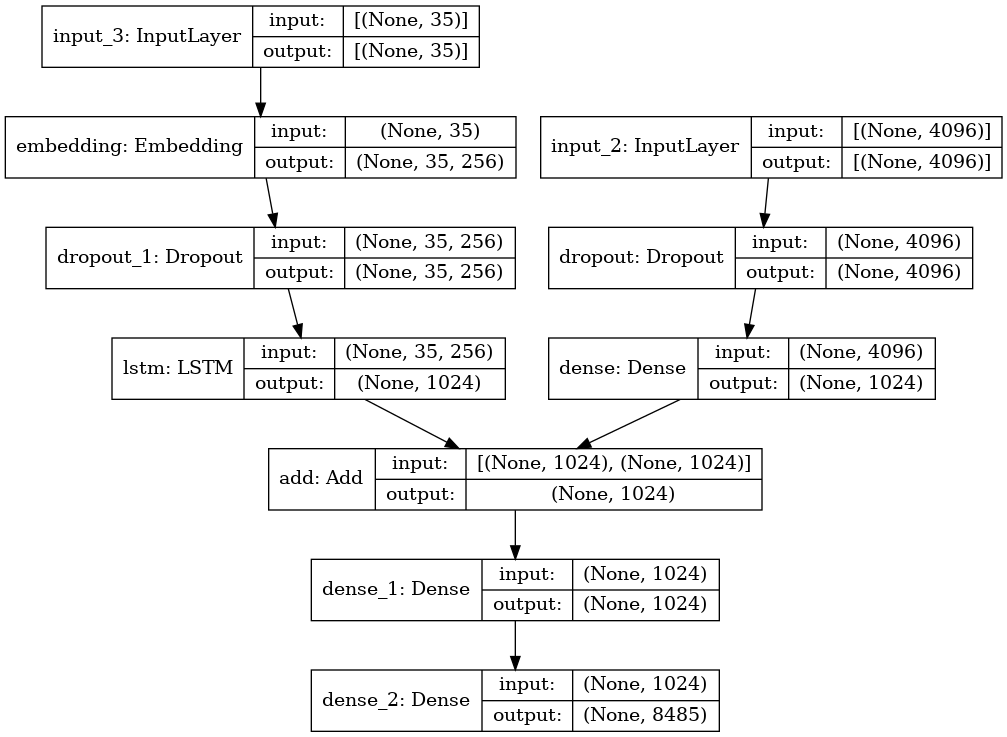

In [16]:
plot_model(model, show_shapes=True)

In [ ]:
def train(data, epochs, batch_size):
    steps = len(data) // batch_size
    for i in range(epochs):
        generator = data_generator(data, img_cap_dict, features, tokenizer, max_len, vocab_size, batch_size)
        model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [9]:
img_ids = list(img_cap_dict.keys())
train_data = img_ids[:int(len(img_ids) * 0.8)]
test_data = img_ids[int(len(img_ids) * 0.8):]

train(train_data, epochs=10, batch_size=64)

101/101 [==============================] - 84s 831ms/step - loss: 2.1795


In [10]:
def idx_to_word(intgr, tokenizer):
    for word, idx in tokenizer.word_index.items():
        if idx == intgr:
            return word
    return None

In [11]:
def predict_captions(model, image, tokenizer, max_len):
    in_text = 'startseq'
    for i in range(max_len):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], max_len)
        prd = model.predict([image, seq], verbose=0)
        prd = np.argmax(prd)
        word = idx_to_word(prd, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

------------------real captions------------------

['startseq man in red shirt shopping for candy endseq', 'startseq person wearing homemade storm trooper helmet looking at display of candy endseq', 'startseq young man wearing large space helmet is looking at candy in market endseq', 'startseq man with storm trooper head gear on shops for candy endseq', 'startseq person standing in front of colorful display of candy endseq']
------------------pred captions------------------

startseq man in red shirt is standing in crowded street endseq


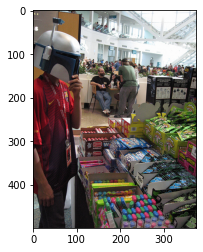

In [31]:
import cv2
import matplotlib.pyplot as plt

rndm_idx = np.random.randint(0, len(test_data))
test_img_id = test_data[rndm_idx]
captions = img_cap_dict[test_img_id]
y_prd = predict_captions(model, features[test_img_id], tokenizer, max_len) 
img = cv2.imread('../input/flickr8k/Images/' + test_img_id + '.jpg', 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print("------------------real captions------------------\n")
print(captions)
print("------------------pred captions------------------\n")
print(y_prd)